# In-between uncertainty

In [2]:
import jax
import numpy as np
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
from functools import partial
import matplotlib.pyplot as plt

In [3]:
from rebayes_mini.methods import low_rank_last_layer as l3rfilter

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
sns.set_palette("colorblind")

In [6]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (7.2, 4.2)

plt.rcParams["font.size"] = 12
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
# plt.rc("text", usetex=True)

In [7]:
jnp.set_printoptions(suppress=True, precision=5, linewidth=200)

In [8]:
qlow = 0.25
qhigh = 0.75

## Test function

In [150]:
def sample_fn(key, n_samples, noise=0.):
    key_W, key_b, key_x, key_y = jax.random.split(key, 4)


    W = jax.random.normal(key_W, (30, 1))
    b = jax.random.normal(key_b, (30, 1)) * 2 * jnp.pi * 0.0

    x1, x2 = jax.random.normal(key_x, (2, n_samples))
    y_err = jax.random.normal(key_y, n_samples)
    
    x = 5 * jnp.sign(x1) + x2.clip(-2, 2)
    y = jnp.cos(W * x + b).sum(axis=0) / 2.0 + noise * y_err

    return x / 10,  y

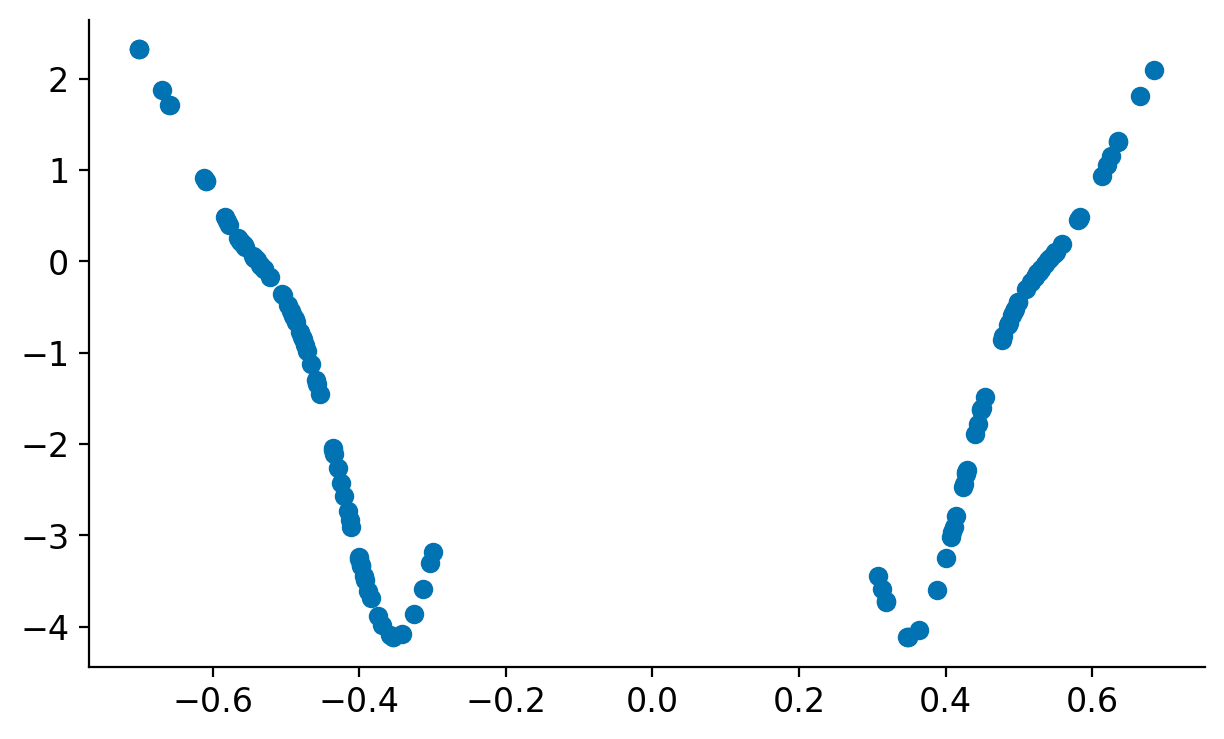

In [151]:
key = jax.random.PRNGKey(3)
key_sample, key_train = jax.random.split(key)

n_samples = 128

xrange = jnp.linspace(-0.8, 0.8, 200)
x_samples, y_samples = sample_fn(key_sample, n_samples)
plt.scatter(x_samples, y_samples)

## Single-pass LL-LRKF

In [377]:
class MLP(nn.Module):
    n_hidden: int = 128

    @nn.compact
    def encode(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        return x

    @nn.compact
    def __call__(self, x):
        x = self.encode(x)
        x = nn.Dense(1, name="last_layer")(x)
        return x

In [378]:
key_init_params, key_hidden, key_last = jax.random.split(key_train, 3)

In [379]:
y_samples.var()

Array(3.14054, dtype=float32)

In [380]:
from rebayes_mini.callbacks import get_updated_bel

In [398]:
%%time
rank = 50
model = MLP()
params_init = model.init(key_init_params, x_samples[:, None])

def cov_fn(y): return 0.0
agent = l3rfilter.LowRankLastLayer(
    model.apply, cov_fn, dynamics_hidden=0.0, dynamics_last=0.0, rank=rank,
)

cov_hidden = 0.5
cov_last = 0.5
bel_init = agent.init_bel(
    params_init, cov_hidden=cov_hidden, cov_last=cov_last, low_rank_diag=False
)


bel_init = bel_init.replace(
    mean_hidden=cov_hidden * jax.random.normal(key_hidden, (len(bel_init.mean_hidden)),),
    mean_last=cov_last*jax.random.normal(key_hidden, (len(bel_init.mean_last)),),
)
bel, bel_hist = agent.scan(bel_init, y_samples, x_samples[:, None], get_updated_bel)
bel = jax.block_until_ready(bel)

@partial(jax.vmap, in_axes=(0, None))
def ppvar(x, bel):
    Lt = agent.jac_last(bel.mean_hidden, bel.mean_last, x)
    Ht = agent.jac_hidden(bel.mean_hidden, bel.mean_last, x)
    var = (
         Lt @ bel.loading_last.T @ bel.loading_last @ Lt.T
        + Ht @ bel.loading_hidden.T @ bel.loading_hidden @ Ht.T
        + cov_fn(1.0)
    )
    return var

pvar_x = jnp.sqrt(ppvar(xrange[:, None],bel).squeeze())
pmean_x = agent.mean_fn(bel.mean_hidden, bel.mean_last, xrange[:, None]).squeeze()

CPU times: user 5.34 s, sys: 98.3 ms, total: 5.44 s
Wall time: 1.93 s


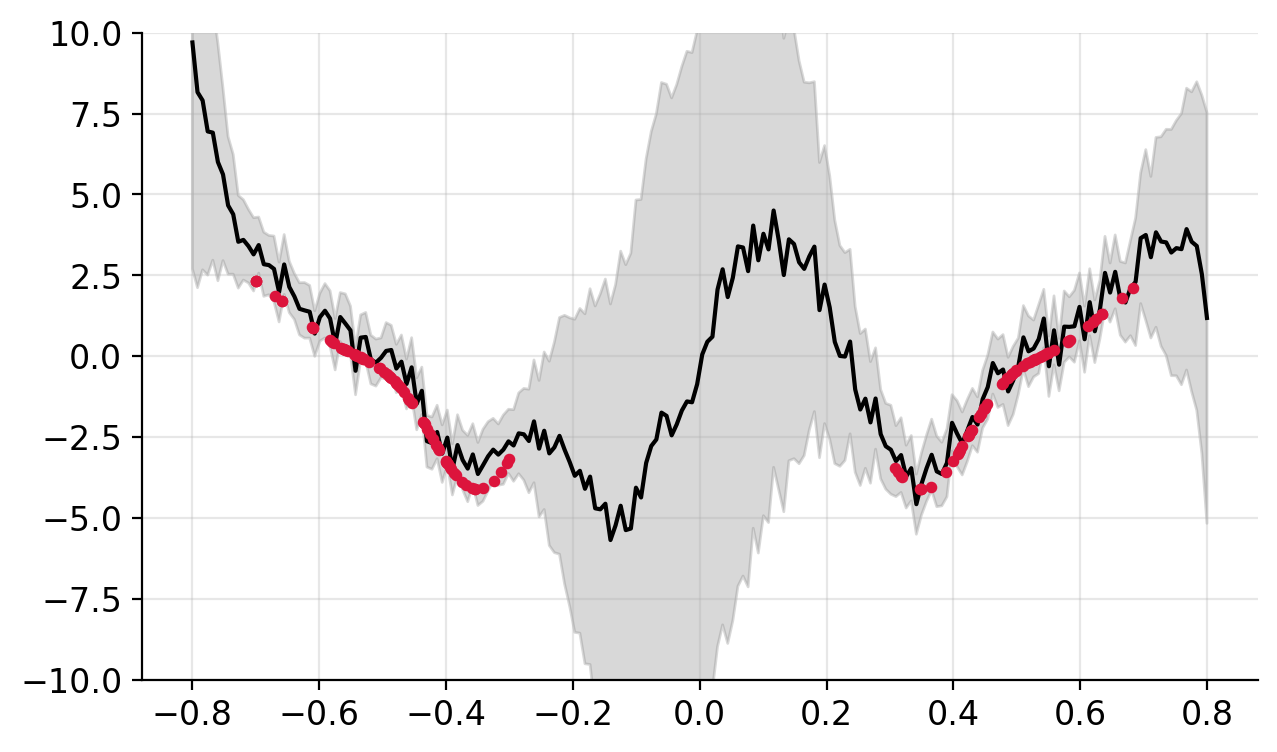

In [399]:
plt.fill_between(xrange, pmean_x - 2 * pvar_x, pmean_x + 2  *  pvar_x, color="gray", alpha=0.3)
plt.plot(xrange, pmean_x, c="black")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3, s=10)
plt.ylim(-10, 10)
plt.grid(alpha=0.3)

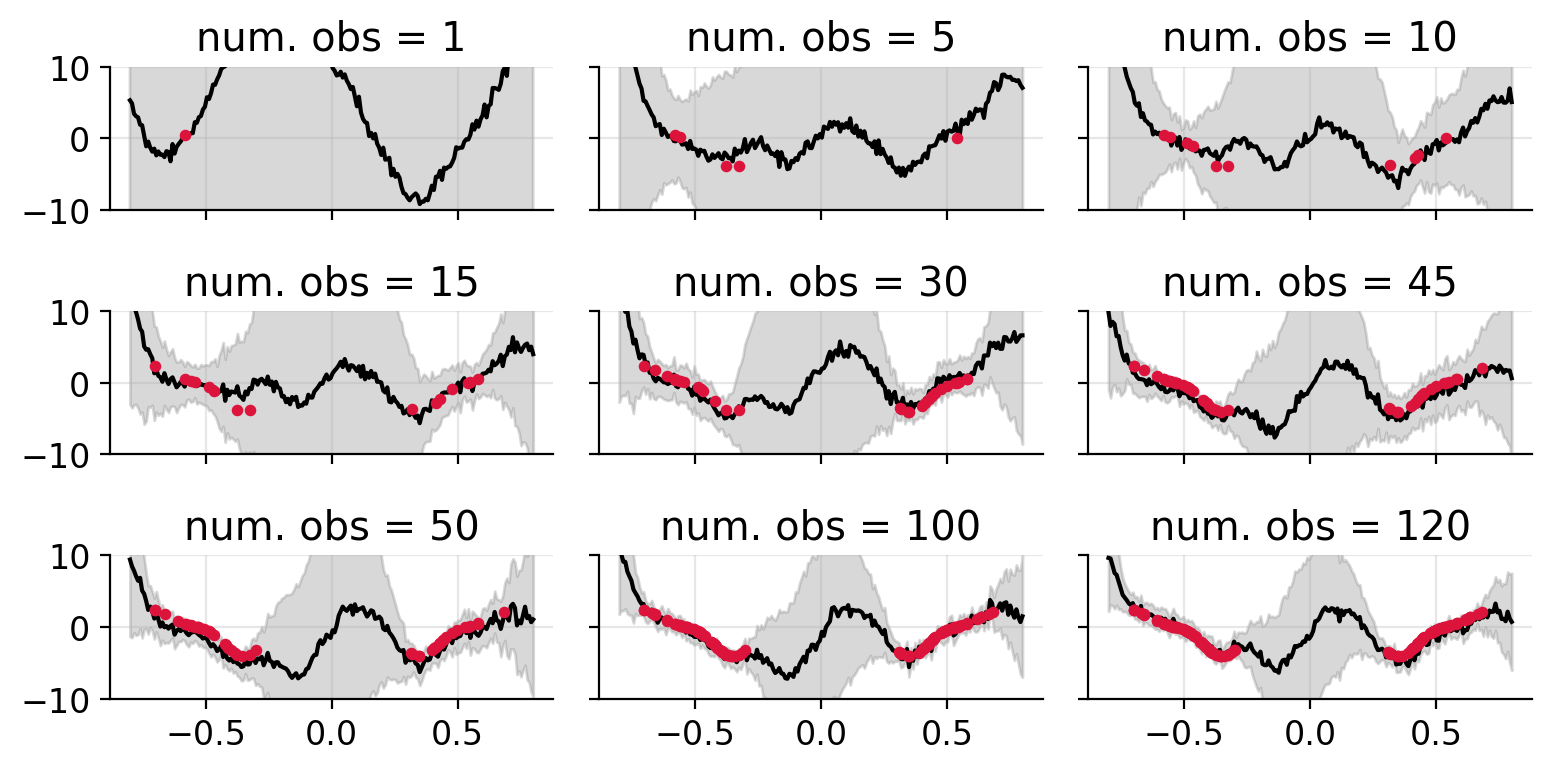

In [401]:
timesteps = [1, 5, 10, 15, 30, 45, 50, 100, 120]
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(7.2 * 1.1, 4))
for axi, timestep in zip(axs.ravel(), timesteps):
    bel = jax.tree.map(lambda x: x[timestep], bel_hist)

    pvar_x = jnp.sqrt(ppvar(xrange[:, None],bel).squeeze())
    pmean_x = agent.mean_fn(bel.mean_hidden, bel.mean_last, xrange[:, None]).squeeze()
    axi.fill_between(xrange, pmean_x - 2 * pvar_x, pmean_x + 2  *  pvar_x, color="gray", alpha=0.3)
    axi.plot(xrange, pmean_x, c="black")
    axi.scatter(x_samples[:timestep], y_samples[:timestep], c="crimson", zorder=3, s=10)
    plt.ylim(-10, 10)
    axi.grid(alpha=0.3)
    axi.set_title(f"num. obs = {timestep}")
plt.tight_layout()
plt.savefig("../figures/in-between-by-timestep.png", dpi=300, bbox_inches="tight")

## Multiple ranks

In [275]:
ranks = [1, 5, 10, 20, 50, 100]

In [167]:
%%time
results = {}
for rank in ranks:
    model = MLP()
    params_init = model.init(key_init_params, x_samples[:, None])
    
    def cov_fn(y): return 0.0
    agent = l3rfilter.LowRankLastLayer(
        model.apply, cov_fn, dynamics_hidden=0.0, dynamics_last=0.0, rank=rank,
    )
    
    cov_hidden = 0.5
    cov_last = 0.5
    bel_init = agent.init_bel(
        params_init, cov_hidden=cov_hidden, cov_last=cov_last, low_rank_diag=True
    )
    
    
    bel_init = bel_init.replace(
        mean_hidden=cov_hidden * jax.random.normal(key_hidden, (len(bel_init.mean_hidden)),),
        mean_last=cov_last*jax.random.normal(key_hidden, (len(bel_init.mean_last)),),
    )
    bel, _ = agent.scan(bel_init, y_samples, x_samples[:, None])
    bel = jax.block_until_ready(bel)
    
    @jax.vmap
    def ppvar(x):
        Ht = agent.jac_last(bel.mean_hidden, bel.mean_last, x)
        return  Ht @ bel.loading_last.T @ bel.loading_last @ Ht.T + cov_fn(1.0)
    
    pvar_x = jnp.sqrt(ppvar(xrange[:, None]).squeeze())
    pmean_x = agent.mean_fn(bel.mean_hidden, bel.mean_last, xrange[:, None]).squeeze()

    results[rank] = {
        "mean": pmean_x,
        "var": pvar_x,
    }
results = jax.tree.map(np.array, results)

CPU times: user 23.1 s, sys: 656 ms, total: 23.8 s
Wall time: 9.36 s


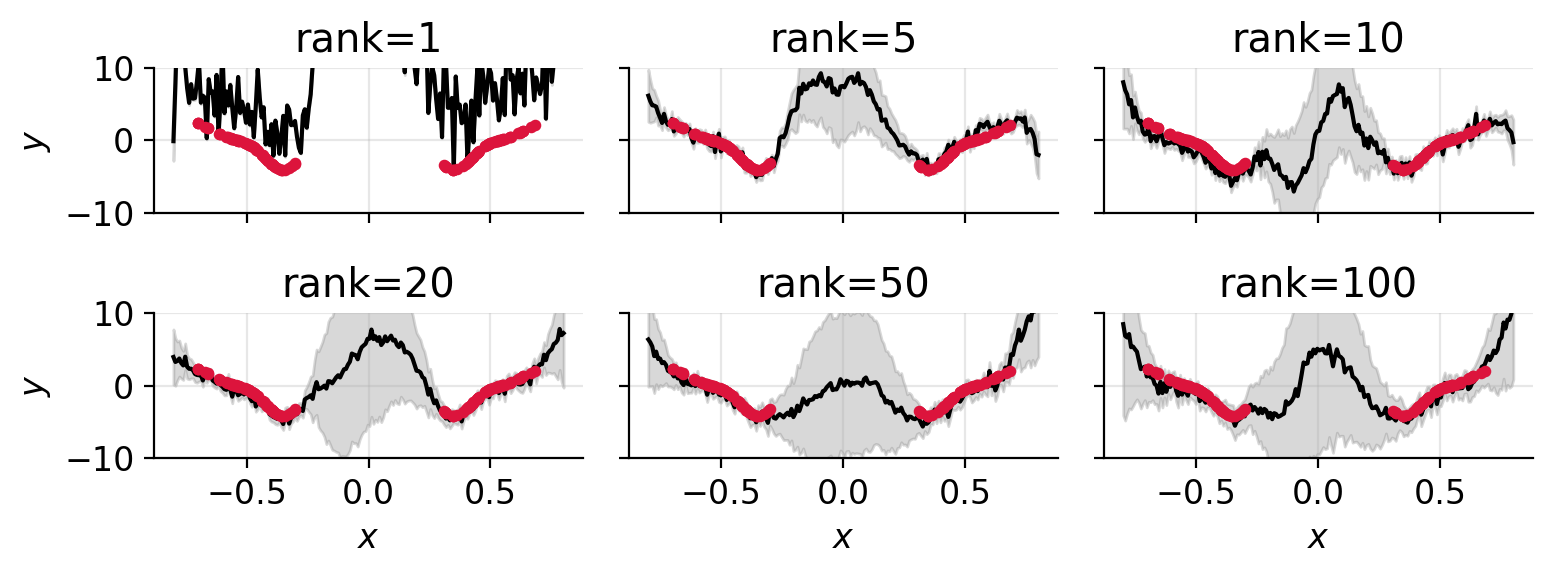

In [177]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(7.2 * 1.1, 3))
for axi, (rank, res) in zip(axs.ravel(), results.items()):
    pmean_x = res["mean"]
    pstd_x = res["var"]

    axi.fill_between(xrange, pmean_x - 2 * pstd_x, pmean_x + 2  *  pstd_x, color="gray", alpha=0.3)
    axi.plot(xrange, pmean_x, c="black")
    axi.scatter(x_samples, y_samples, c="crimson", zorder=3, s=10)
    axi.set_ylim(-10, 10)
    axi.set_title(f"rank={rank}")
    axi.grid(alpha=0.3)
    
for axi in axs[1, :]:
    axi.set_xlabel("$x$")

for axi in axs[:, 0]:
    axi.set_ylabel("$y$")

plt.tight_layout()
plt.savefig("../figures/in-between-by-rank.png", dpi=300, bbox_inches="tight")

# Last-layer methods

In [246]:
import optax
from flax.training.train_state import TrainState
from vbll.jax.layers import Regression

/home/gerardoduran/miniconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/gerardoduran/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## MLP

In [247]:
mlp = MLP()
params_init = model.init(key_train, x_samples[:, None])
jax.tree.map(jnp.shape, params_init)

{'params': {'Dense_0': {'bias': (128,), 'kernel': (1, 128)},
  'Dense_1': {'bias': (128,), 'kernel': (128, 128)},
  'Dense_2': {'bias': (128,), 'kernel': (128, 128)},
  'Dense_3': {'bias': (128,), 'kernel': (128, 128)},
  'last_layer': {'bias': (1,), 'kernel': (128, 1)}}}

In [248]:
@jax.value_and_grad
def eval_grads(params):
    yhat = mlp.apply(params, x_samples[:, None]).squeeze()
    errs = jnp.power(yhat - y_samples, 2)
    return errs.mean()

In [249]:
state = TrainState.create(
    apply_fn=eval_grads,
    params=params_init,
    tx=optax.adamw(1e-3)
)

In [250]:
def step(state, _):
    loss, grads = state.apply_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [251]:
n_epochs = 2000
epochs = jnp.arange(n_epochs)
state_final, losses = jax.lax.scan(step, state, epochs)

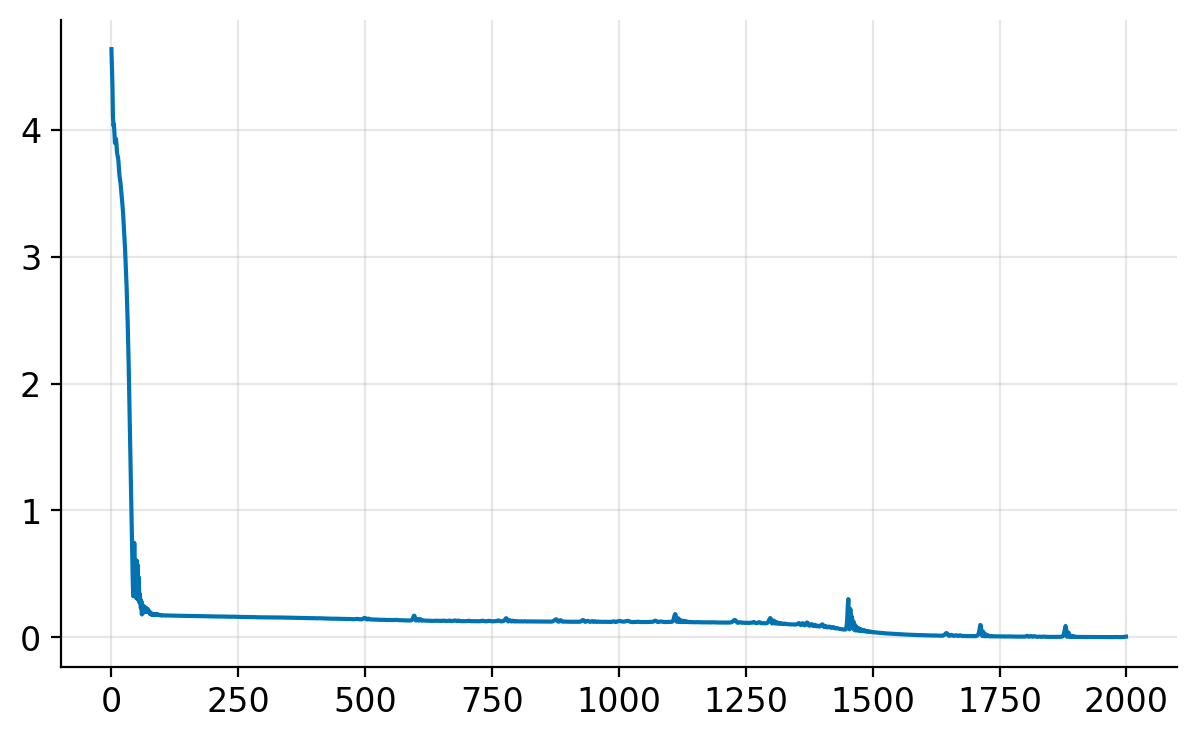

In [252]:
plt.plot(losses)
plt.grid(alpha=0.3)
# plt.yscale("log")

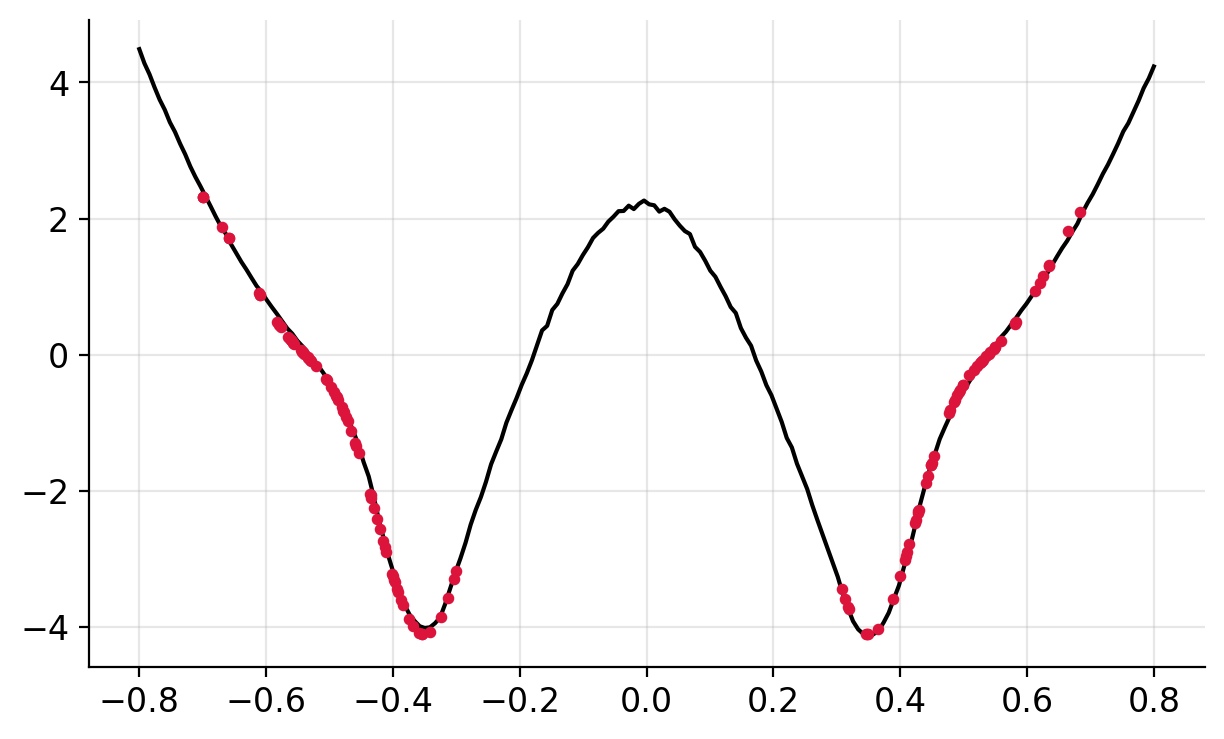

In [253]:
yhat = mlp.apply(state_final.params, xrange[:, None])
plt.plot(xrange, yhat, c="black")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3, s=10)
plt.grid(alpha=0.3)

## VBLL

Sources:
1. [Notebook example in Pytorch](https://colab.research.google.com/github/VectorInstitute/vbll/blob/main/docs/tutorials/VBLL_Regression.ipynb#scrollTo=dOUWXc9HLI0T)
2. [Regression layer definition](https://github.com/VectorInstitute/vbll/blob/main/vbll/jax/layers/regression.py)

In [405]:
class VBLLMLP(nn.Module):
    n_hidden: int = 64

    @nn.compact
    def encode(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        return x

    @nn.compact
    def __call__(self, x):
        x = self.encode(x)
        x = Regression(
            in_features=self.n_hidden, out_features=1,
            wishart_scale=0.1,
            regularization_weight=1 / len(y_samples),
        )(x)
        return x

In [406]:
vbll = VBLLMLP()
params_init = vbll.init(key_train, x_samples[:, None])
jax.tree.map(jnp.shape, params_init)

{'params': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)},
  'Dense_1': {'bias': (64,), 'kernel': (64, 64)},
  'Dense_2': {'bias': (64,), 'kernel': (64, 64)},
  'Dense_3': {'bias': (64,), 'kernel': (64, 64)},
  'Regression_0': {'W_logdiag': (1, 64),
   'W_mean': (1, 64),
   'W_offdiag': (1, 64, 64),
   'noise_logdiag': (1,),
   'noise_mean': (1,)}}}

### Train loop

In [407]:
@jax.value_and_grad
def eval_grads(params):
    res = vbll.apply(params, x_samples[:, None])
    return res.train_loss_fn(y_samples[:, None])

In [445]:
state_init = TrainState.create(
    apply_fn=eval_grads,
    params=params_init,
    tx=optax.adamw(1e-3)
)

In [446]:
def step(state, _):
    loss, grads = state.apply_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [453]:
%%time
n_epochs = 10_000
epochs = jnp.arange(n_epochs)
state_final, losses = jax.lax.scan(step, state_init, epochs)
state_final = jax.block_until_ready(state_final)

CPU times: user 1.24 s, sys: 51.9 ms, total: 1.29 s
Wall time: 1.49 s


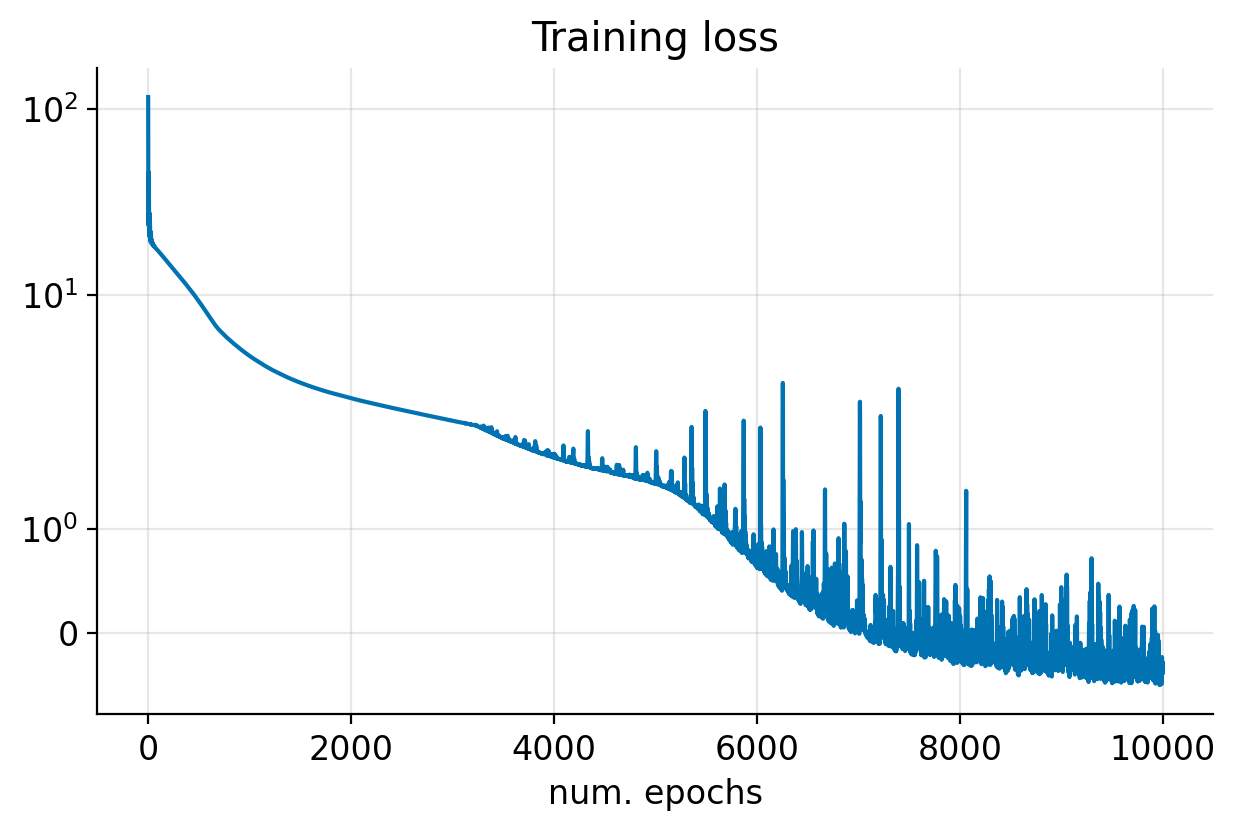

In [454]:
plt.plot(losses)
plt.yscale("symlog")
plt.title("Training loss")
plt.xlabel("num. epochs")
plt.grid(alpha=0.3)

## Posterior predictive

In [ ]:
res = vbll.apply(state_final.params, xrange[:, None])
y_test_predictive = res.predictive
y_test_mu = y_test_predictive.mean
y_test_sigma = jnp.sqrt(y_test_predictive.covariance_diagonal)

lbound = y_test_mu - 2 * y_test_sigma
ubound = y_test_mu + 2 * y_test_sigma

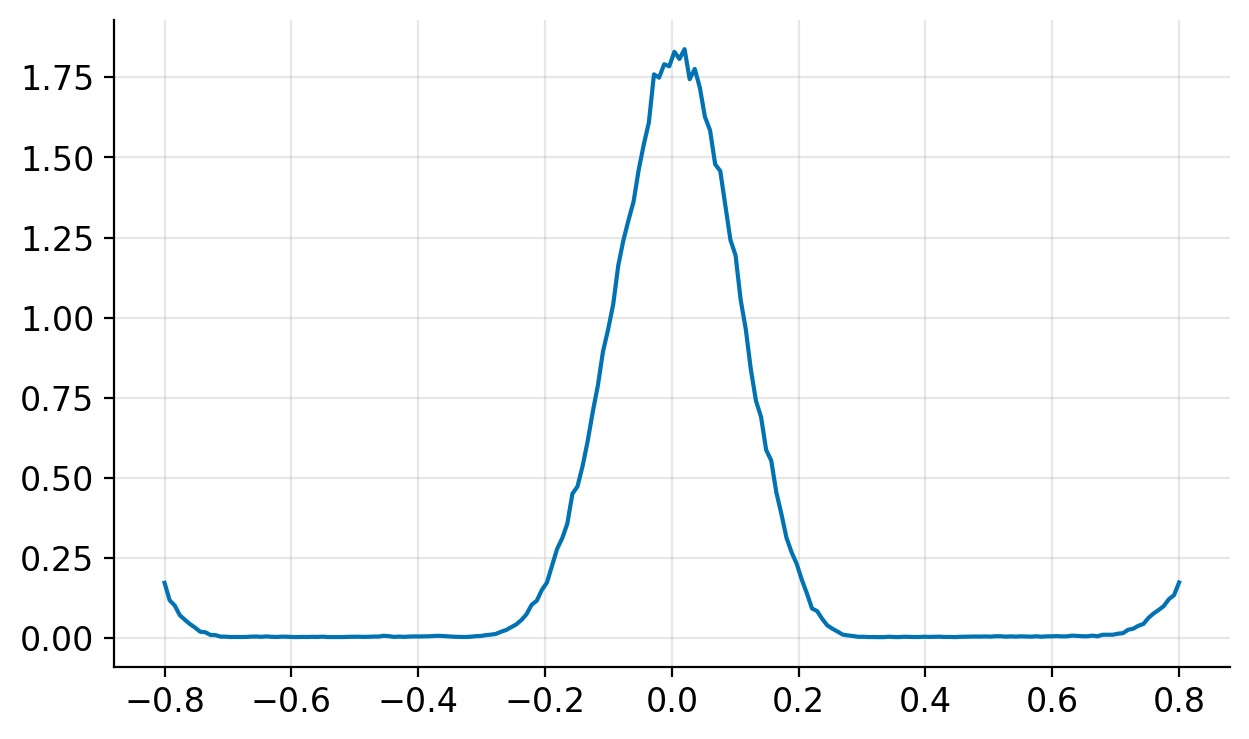

In [457]:
plt.plot(xrange, y_test_predictive.covariance_diagonal)
plt.grid(alpha=0.3)

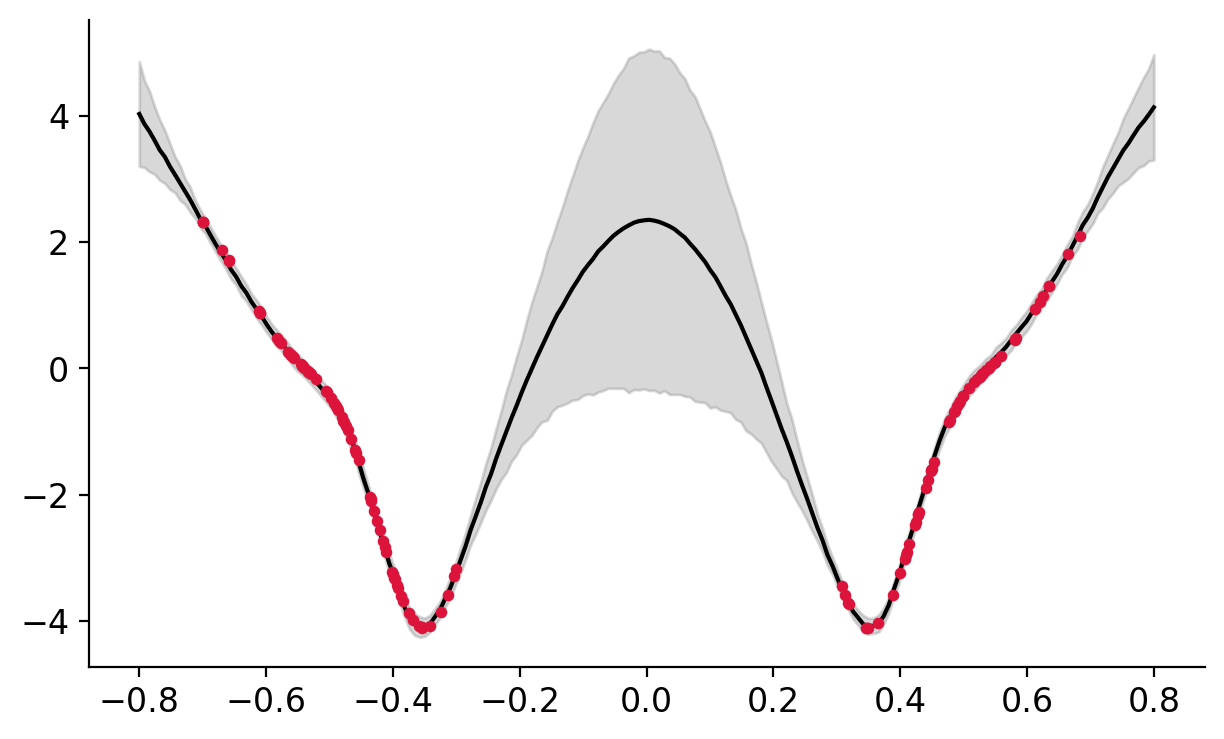

In [458]:
plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.3)
plt.plot(xrange, y_test_mu, color="black")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3, s=10)

## Multiple epochs

/tmp/ipykernel_2818970/3313255562.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1].set_xscale("log")


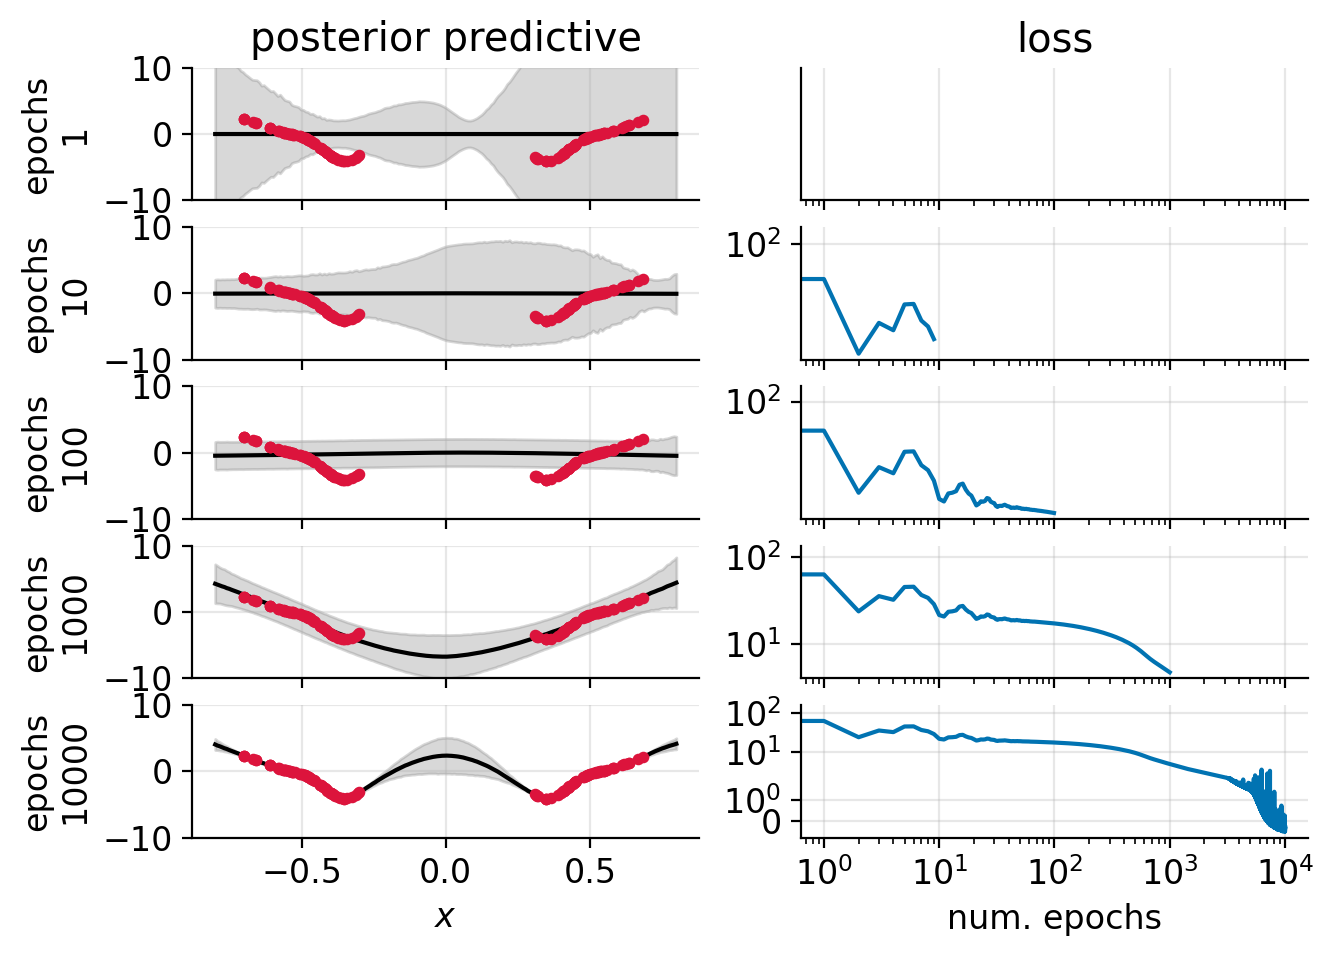

In [501]:
fig, axs = plt.subplots(5, 2, figsize=(7.2, 5), sharex="col")

eopchs_test = [1, 10, 100, 1_000, 10_000]
for ax, n_epochs in zip(axs, eopchs_test):
    epochs = jnp.arange(n_epochs)
    state_final, losses = jax.lax.scan(step, state_init, epochs)
    state_final = jax.block_until_ready(state_final)
    
    res = vbll.apply(state_final.params, xrange[:, None])
    y_test_predictive = res.predictive
    y_test_mu = y_test_predictive.mean
    y_test_sigma = jnp.sqrt(y_test_predictive.covariance_diagonal)
    
    lbound = y_test_mu - 2 * y_test_sigma
    ubound = y_test_mu + 2 * y_test_sigma
    
    ax[0].fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.3)
    ax[0].plot(xrange, y_test_mu, color="black")
    ax[0].scatter(x_samples, y_samples, c="crimson", zorder=3, s=10)
    ax[0].grid(alpha=0.3)
    ax[0].set_ylim(-10, 10)
    ax[0].set_ylabel(f"epochs\n{n_epochs}")
    
    ax[1].plot(losses)
    ax[1].set_yscale("symlog")
    ax[1].set_xscale("log")
    # ax[1].set_xlabel("num. epochs")
    ax[1].grid(alpha=0.3)
# plt.tight_layout()
axs[0, 0].set_title("posterior predictive")
axs[0, 1].set_title("loss")

axs[-1, 0].set_xlabel("$x$")
axs[-1, 1].set_xlabel("num. epochs")
plt.savefig("../figures/in-between-uncertainty-vbll.png", dpi=300, bbox_inches="tight")

## Online VBLL

In [417]:
from vbll_fifo import FifoVBLL
from vbll_fifo import RegressionRefac as RegressionFifo

In [418]:
class VBLLMLP(nn.Module):
    regularization_weight: float
    n_hidden: int = 64

    @nn.compact
    def encode(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        return x

    @nn.compact
    def __call__(self, x):
        x = self.encode(x)
        x = RegressionFifo(
            in_features=self.n_hidden, out_features=1,
            wishart_scale=0.1,
            regularization_weight=self.regularization_weight,
        )(x)
        return x

In [419]:
learning_rate = 1e-3
buffer_size = 50
n_inner = 100
vbl_mlp = VBLLMLP(regularization_weight=0.0)
params_init_vbll = vbl_mlp.init(key_train, x_samples[:, None])

def lossfn(params, counter, x, y, apply_fn):
    res = apply_fn(params, x)
    return res.train_loss_fn(y, counter)

dim_features = 1
agent = FifoVBLL(
    vbl_mlp.apply,
    lossfn,
    tx=optax.adamw(learning_rate),
    buffer_size=buffer_size,
    dim_features=dim_features,
    dim_output=1,
    n_inner=n_inner,
)

In [420]:
%%time
bel_init = agent.init_bel(params_init_vbll)
bel_final, _ = agent.scan(bel_init, y_samples, x_samples[:, None])
bel_final = jax.block_until_ready(bel_final)

CPU times: user 2.42 s, sys: 67.3 ms, total: 2.49 s
Wall time: 2.64 s


## Result

In [421]:
res = vbl_mlp.apply(bel_final.params, xrange[:, None])
y_test_predictive = res.predictive
y_test_mu = y_test_predictive.mean
y_test_sigma = jnp.sqrt(y_test_predictive.covariance_diagonal)

In [422]:
lbound = y_test_mu - 2 * y_test_sigma
ubound = y_test_mu + 2 * y_test_sigma

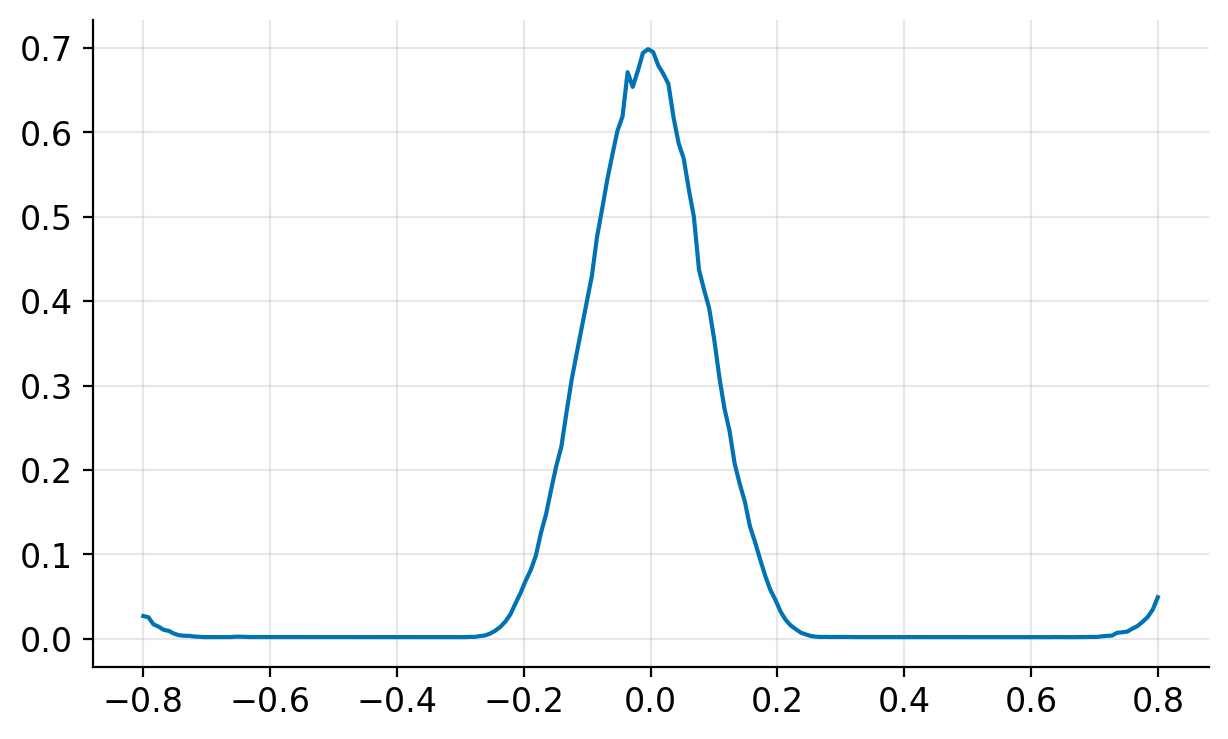

In [423]:
plt.plot(xrange, y_test_predictive.covariance_diagonal)
plt.grid(alpha=0.3)

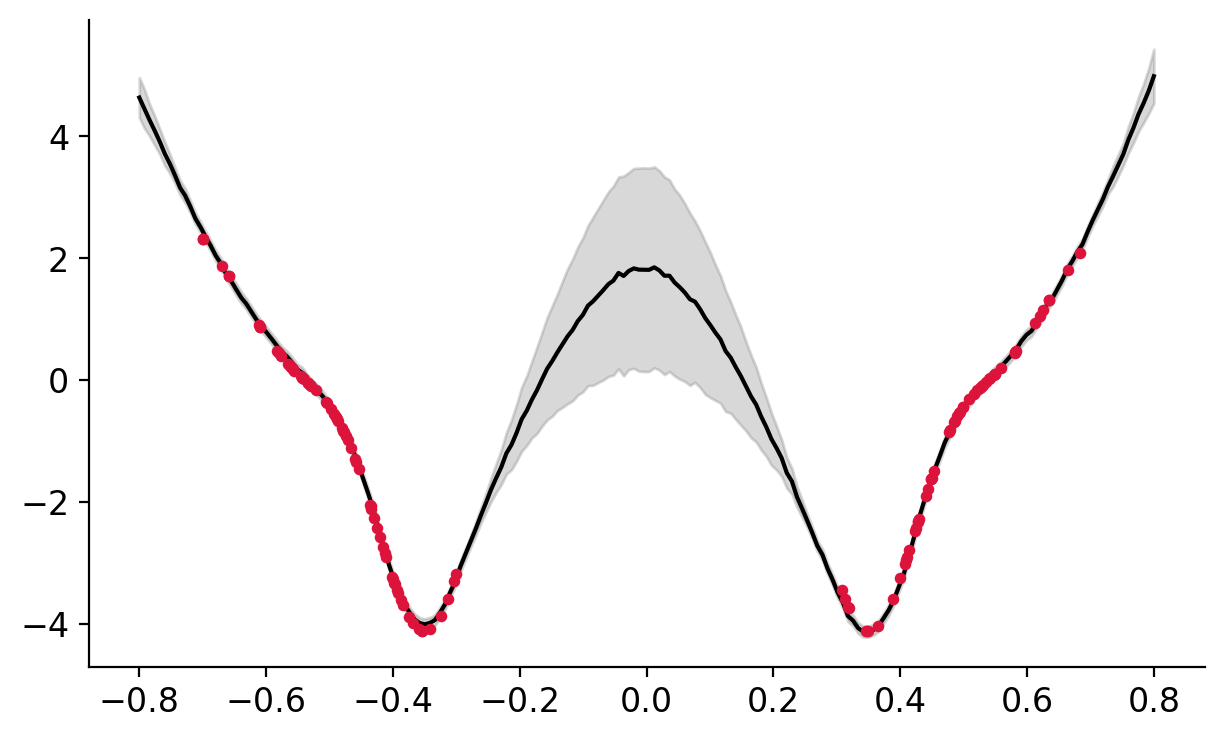

In [424]:
plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.3)
plt.plot(xrange, y_test_mu, color="black")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3, s=10)